In [1]:
import os

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import Sequence, pad_sequences

from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, AdditiveAttention, Add, Concatenate, Dropout, Reshape

from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

from nltk.translate.bleu_score import corpus_bleu

# Load data

In [2]:
def load_data(path):

    with open(path + 'captions.txt', 'r', encoding='utf-8') as file:

        lines = file.readlines()



    data = [line.split('\t', 1) for line in lines]

    df = pd.DataFrame(data, columns=["image_path", "caption"])



    return df

In [3]:
dataset_path = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/dataset'

train_path = dataset_path + '/train/'

val_path = dataset_path + '/val/'

test_path = dataset_path + '/test/'

In [4]:
df_train = load_data(train_path)

df_val = load_data(val_path)

df_test = load_data(test_path)

In [5]:
df_train

,image_path,caption
0,/dataset/train/images/000000157656.jpg,Người đàn ông đang đánh tennis ngoài sân.\n
1,/dataset/train/images/000000157656.jpg,Một vận động viên tennis đang vung vợt đánh bó...
2,/dataset/train/images/000000157656.jpg,Một cầu thủ tennis đang vung vợt tennis đỡ bón...
3,/dataset/train/images/000000157656.jpg,Người đàn ông đang đứng ngoài biên cầm vợt sẵn...
4,/dataset/train/images/000000157656.jpg,Vận động viên tennis nam đang trong tư thế chu...
...,...,...
13476,/dataset/train/images/000000121943.jpg,Những cô gái đang chơi bóng đá ở trên sân .\n
13477,/dataset/train/images/000000466840.jpg,Những người đàn ông đang chơi bóng chày trên s...
13478,/dataset/train/images/000000381377.jpg,Một số người mặc đồ đá bóng đang đá bóng trên ...
13479,/dataset/train/images/000000561746.jpg,Một người đàn ông đang dùng vợt để đánh quả bó...


# Preprocess data

In [6]:
def text_preprocessing(df):

    df_preprocessed = df.copy()

    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: x.lower())

    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))

    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: x.replace("\s+"," "))

    df_preprocessed['caption'] = df_preprocessed['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

    df_preprocessed['caption'] = "startseq "+df_preprocessed['caption']+" endseq"

    df_preprocessed['image_path'] = df_preprocessed['image_path'].str.replace('^/dataset', '', regex=True)

    df_preprocessed['image_path'] = dataset_path + df_preprocessed['image_path']

    return df_preprocessed

In [7]:
df_train_preprocessed = text_preprocessing(df_train)

df_val_preprocessed = text_preprocessing(df_val)

df_test_preprocessed = text_preprocessing(df_test)

In [8]:
df_train_preprocessed

,image_path,caption
0,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq người đàn ông đang đánh tennis ngoài ...
1,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq một vận động viên tennis đang vung vợ...
2,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq một cầu thủ tennis đang vung vợt tenn...
3,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq người đàn ông đang đứng ngoài biên cầ...
4,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq vận động viên tennis nam đang trong t...
...,...,...
13476,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq những cô gái đang chơi bóng đá trên s...
13477,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq những người đàn ông đang chơi bóng ch...
13478,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq một số người mặc đồ đá bóng đang đá b...
13479,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,startseq một người đàn ông đang dùng vợt để đá...


# Tokenizer

In [9]:
captions = df_train_preprocessed['caption'].tolist() + df_val_preprocessed['caption'].tolist() + df_test_preprocessed['caption'].tolist()

tokenizer = Tokenizer()

tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in captions)



tokenizer.texts_to_sequences([captions[1]])[0]

[1, 7, 20, 17, 18, 5, 4, 39, 16, 10, 3, 2]

# Feature extractor

In [10]:
base_model = DenseNet201()



feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)



image_features = {}



all_images = df_train_preprocessed['image_path'].unique().tolist() + df_val_preprocessed['image_path'].unique().tolist() + df_test_preprocessed['image_path'].unique().tolist()

for image in tqdm(all_images):

    img = load_img(image,target_size=(224,224))

    img = img_to_array(img)

    img = img/255.

    img = np.expand_dims(img,axis=0)

    feature = feature_extractor.predict(img, verbose=0)

    image_features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/3850 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1735310420.386587      68 service.cc:145] XLA service 0x7ebf140049f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735310420.386651      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1735310420.386655      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1735310432.508180      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 3850/3850 [06:07<00:00, 10.48it/s]


In [11]:
np.savez("image_features.npz", **image_features) # lưu features trích xuất từ các images về máy

# Build model

In [12]:
# Input ảnh
image_input = Input(shape=(1920,))
cnn_features = Dense(256, activation='relu')(image_input)
cnn_features_reshaped = Reshape((1, 256), input_shape=(256,))(cnn_features)

# --- Input câu và xử lý với Embedding ---
# Input câu
sentence_input = Input(shape=(max_length,))  # Shape: (batch_size, max_length)

# Embedding từ vựng
sentence_embedding = Embedding(vocab_size, 256, mask_zero=True, name="sentence_embedding")(sentence_input)

# --- 3. LSTM để tạo hidden state ---
# LSTM cho câu chú thích
lstm_output = LSTM(256, use_cudnn=True)(sentence_embedding)
lstm_output = Dropout(0.5)(lstm_output)

# --- 4. Attention Mechanism ---
# Sử dụng Additive Attention
attention_output = AdditiveAttention(dropout=0.2, use_scale=True)([lstm_output, cnn_features])
attention_output = Dropout(0.5)(attention_output)

# Kết hợp Attention Output và LSTM Output
x = Add()([attention_output, lstm_output])
x = Concatenate(axis=-1)([x, cnn_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# --- 5. Dự đoán từ tiếp theo ---
# Fully Connected Layer để tạo đầu ra từ vựng
output = Dense(vocab_size, activation="softmax")(x)

# --- 6. Xây dựng mô hình ---
model = Model(inputs=[image_input, sentence_input], outputs=output)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentence_embedding  │ (None, 35, 256)   │    345,856 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ sentence_embeddi… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 256)       │        256 │ dropout[0][0],    │
│ (AdditiveAttention) │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ add[0][0],        │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1351)      │    174,279 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,603,143 (6.12 MB)

 Trainable params: 1,603,143 (6.12 MB)

 Non-trainable params: 0 (0.00 B)

# Prepare data for training

In [13]:
def DataGenerator(df, tokenizer=tokenizer, max_length=max_length, image_features=image_features):

    image_input, sentence_input, output = list(), list(), list()

    for i in range(len(df)):

        image_path = df.iloc[i]['image_path']

        caption = df.iloc[i]['caption']

        caption_sequence = tokenizer.texts_to_sequences([caption])[0]

        for j in range(1, len(caption_sequence)):

            in_sequence, out_word = caption_sequence[:j], caption_sequence[j]

            in_sequence = pad_sequences([in_sequence], maxlen=max_length, padding='post')[0]

            out_word = tf.keras.utils.to_categorical([out_word], num_classes=vocab_size)[0]

            image_input.append(image_features[image_path][0])

            sentence_input.append(in_sequence)

            output.append(out_word)

    return np.array(image_input), np.array(sentence_input), np.array(output)

# Train model

In [14]:
checkpoint_callback = ModelCheckpoint(
    filepath='densenet201_attention.keras',    # Đường dẫn file để lưu mô hình
    monitor='val_loss',          # Theo dõi 'val_loss'
    save_best_only=True,         # Chỉ lưu mô hình tốt nhất
    mode='min',                  # Lưu khi 'val_loss' giảm (tối thiểu)
    verbose=1                    # Hiển thị thông báo khi lưu mô hình
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

train_image_data, train_sentence_data, train_output_data = DataGenerator(df_train_preprocessed)
val_image_data, val_sentence_data, val_output_data = DataGenerator(df_val_preprocessed)

# Huấn luyện mô hình

with tf.device('/GPU:0'):

    history = model.fit(

        x=[train_image_data, train_sentence_data],

        y=train_output_data,

        validation_data=([val_image_data, val_sentence_data], val_output_data),

        epochs=30,  # Số vòng lặp

        batch_size=100, # Kích thước batch
        
        callbacks=[checkpoint_callback]
        
    )

Epoch 1/30
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3018 - loss: 3.6156
Epoch 1: val_loss improved from inf to 1.81964, saving model to densenet201_attention.keras
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.3019 - loss: 3.6151 - val_accuracy: 0.6015 - val_loss: 1.8196
Epoch 2/30
1739/1743 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5971 - loss: 1.8455
Epoch 2: val_loss improved from 1.81964 to 1.57027, saving model to densenet201_attention.keras
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.5971 - loss: 1.8453 - val_accuracy: 0.6445 - val_loss: 1.5703
Epoch 3/30
1740/1743 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6325 - loss: 1.6079
Epoch 3: val_loss improved from 1.57027 to 1.47223, saving model to densenet201_attention.keras
1743/1743 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6325 - loss: 1.6079 - val_accuracy: 0.6629 - val_loss: 1.4722
Epoch 4/30
1742/1743 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6481 - loss: 1.5036
Epo

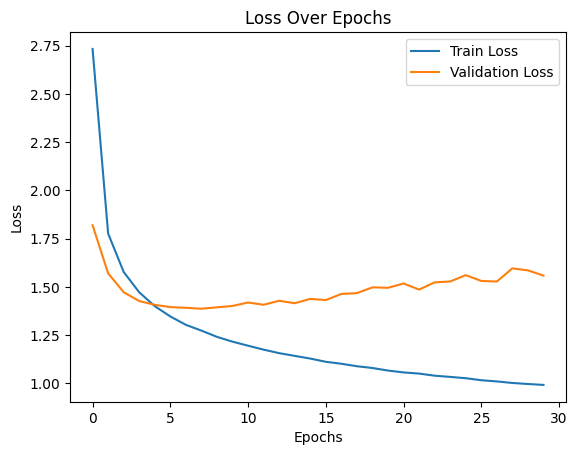

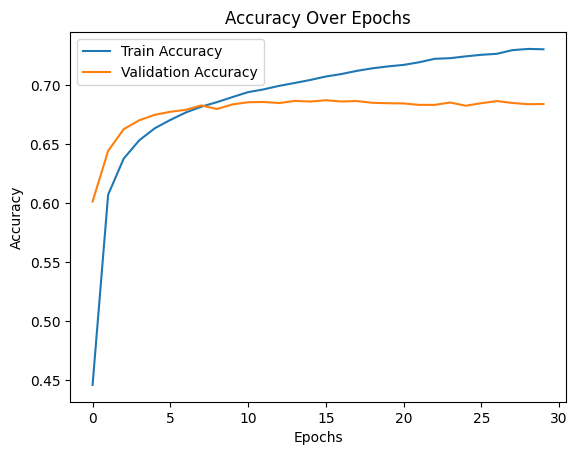

In [16]:
import matplotlib.pyplot as plt



# Vẽ biểu đồ loss

plt.plot(history.history['loss'], label='Train Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.title('Loss Over Epochs')

plt.show()



# Vẽ biểu đồ accuracy

plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.title('Accuracy Over Epochs')

plt.show()

# BLEU metric 

In [17]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [18]:
def predict_caption(model, image, tokenizer=tokenizer, max_length=max_length, features=image_features):
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = image_features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post') #

        y_pred = model.predict([feature,sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [19]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [20]:
df_test_preprocessed['caption'] = df_test_preprocessed['caption'].str.replace(r'^startseq ', '', regex=True)
df_test_preprocessed['caption'] = df_test_preprocessed['caption'].str.replace(r' endseq$', '', regex=True)

In [21]:
df_test_merge = df_test_preprocessed.groupby('image_path')['caption'].apply(list).reset_index()

In [22]:
df_test_merge

,image_path,caption
0,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...
1,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh hai cậu bé đang chơi trong khu dân c...
2,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh một trận thi đấu bóng đá đang diễn r...
3,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người phụ nữ đang vung vợt để đánh quả bó...
4,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cậu bé đang nghiêng người để đánh quả bón...
...,...,...
226,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang dùng vợt để đánh quả b...
227,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang chuẩn bị đánh quả bóng...
228,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ..."
229,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cầu thủ đánh bóng đang xoay người để đánh...


In [23]:
for index,record in df_test_merge.iterrows():
    img = load_img(record['image_path'],target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(model, record['image_path'], tokenizer, max_length, image_features)
    df_test_merge.loc[index,'predict'] = caption

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [24]:
df_test_merge['predict'] = df_test_merge['predict'].str.replace(r'^startseq ', '', regex=True)
df_test_merge['predict'] = df_test_merge['predict'].str.replace(r' endseq$', '', regex=True)

In [25]:
df_test_merge

,image_path,caption,predict
0,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...,một người đàn ông đang chuẩn bị ném quả bóng chày
1,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một số người đang chơi bóng chày trên sân
2,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh một trận thi đấu bóng đá đang diễn r...,những người đàn ông đang chơi bóng đá trên sân
3,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người phụ nữ đang vung vợt để đánh quả bó...,một người phụ nữ đang chuẩn bị đánh quả bóng t...
4,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cậu bé đang nghiêng người để đánh quả bón...,một cậu bé đang chơi bóng đá trên sân
...,...,...,...
226,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang dùng vợt để đánh quả b...,người phụ nữ đang cầm vợt tennis đứng trên sân
227,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang chuẩn bị đánh quả bóng ...
228,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ...",một số người đang chơi bóng đá trên sân
229,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cầu thủ đánh bóng đang xoay người để đánh...,một số người đang chơi bóng chày trên sân


In [26]:
def calculate_bleu_scores(row):
    reference = [caption.split() for caption in row['caption']]
    prediction = row['predict'].split()

    if len(prediction) == 0:
        return pd.Series([0, 0, 0, 0])

    smoothie = SmoothingFunction().method4

    bleu_1 = sentence_bleu(reference, prediction, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu_2 = sentence_bleu(reference, prediction, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu_3 = sentence_bleu(reference, prediction, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu_4 = sentence_bleu(reference, prediction, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return pd.Series([bleu_1, bleu_2, bleu_3, bleu_4])

In [27]:
df_test_merge[['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']] = df_test_merge.apply(calculate_bleu_scores, axis=1)

In [28]:
df_test_merge

,image_path,caption,predict,bleu_1,bleu_2,bleu_3,bleu_4
0,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...,một người đàn ông đang chuẩn bị ném quả bóng chày,0.909091,0.852803,0.741515,0.563756
1,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một số người đang chơi bóng chày trên sân,0.533825,0.326900,0.274455,0.234766
2,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh một trận thi đấu bóng đá đang diễn r...,những người đàn ông đang chơi bóng đá trên sân,0.500000,0.333333,0.302277,0.267894
3,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người phụ nữ đang vung vợt để đánh quả bó...,một người phụ nữ đang chuẩn bị đánh quả bóng t...,1.000000,1.000000,1.000000,1.000000
4,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cậu bé đang nghiêng người để đánh quả bón...,một cậu bé đang chơi bóng đá trên sân,0.533825,0.516874,0.498675,0.470349
...,...,...,...,...,...,...,...
226,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang dùng vợt để đánh quả b...,người phụ nữ đang cầm vợt tennis đứng trên sân,0.600000,0.258199,0.255384,0.235777
227,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang chuẩn bị đánh quả bóng ...,1.000000,1.000000,1.000000,1.000000
228,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ...",một số người đang chơi bóng đá trên sân,0.695986,0.558030,0.433356,0.330101
229,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cầu thủ đánh bóng đang xoay người để đánh...,một số người đang chơi bóng chày trên sân,0.444854,0.211013,0.205590,0.188618


In [29]:
bleu_1_avg = round(df_test_merge['bleu_1'].mean() * 100, 2)
bleu_2_avg = round(df_test_merge['bleu_2'].mean() * 100, 2)
bleu_3_avg = round(df_test_merge['bleu_3'].mean() * 100, 2)
bleu_4_avg = round(df_test_merge['bleu_4'].mean() * 100, 2)

# In kết quả BLEU score trung bình
print("Average BLEU-1 Score:", bleu_1_avg)
print("Average BLEU-2 Score:", bleu_2_avg)
print("Average BLEU-3 Score:", bleu_3_avg)
print("Average BLEU-4 Score:", bleu_4_avg)

Average BLEU-1 Score: 65.68
Average BLEU-2 Score: 52.62
Average BLEU-3 Score: 45.19
Average BLEU-4 Score: 39.29


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

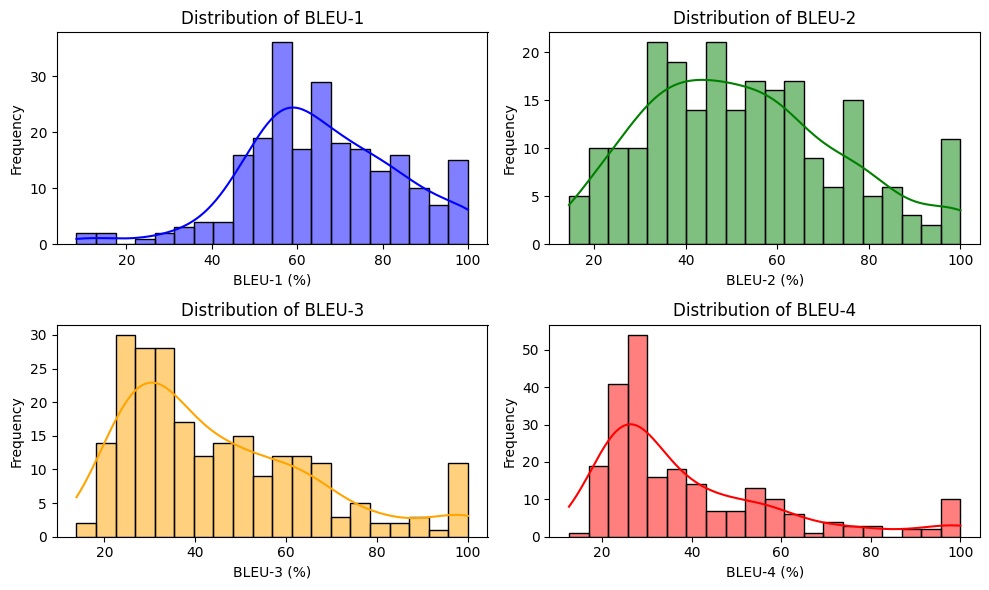

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.histplot(df_test_merge['bleu_1'] * 100, kde=True, bins=20, color='blue', label='BLEU-1')
plt.title('Distribution of BLEU-1')
plt.xlabel('BLEU-1 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(df_test_merge['bleu_2'] * 100, kde=True, bins=20, color='green', label='BLEU-2')
plt.title('Distribution of BLEU-2')
plt.xlabel('BLEU-2 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(df_test_merge['bleu_3'] * 100, kde=True, bins=20, color='orange', label='BLEU-3')
plt.title('Distribution of BLEU-3')
plt.xlabel('BLEU-3 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(df_test_merge['bleu_4'] * 100, kde=True, bins=20, color='red', label='BLEU-4')
plt.title('Distribution of BLEU-4')
plt.xlabel('BLEU-4 (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# ROUGE metric 

In [31]:
!pip install rouge-score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=59c9ccf2f9827183c6eee482ddcfbad73173299b692d066e57fba4f1a1619acb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [32]:
from rouge_score import rouge_scorer

In [33]:
def calculate_rouge_scores(row):
    reference = row['caption']
    prediction = row['predict']

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    total_f1 = 0

    for ref in reference:
        scores = scorer.score(ref, prediction)
        rouge_l = scores['rougeL']
        total_f1 += rouge_l.fmeasure

    avg_f1 = total_f1 / len(reference)

    return avg_f1

In [34]:
df_test_merge['rouge_L'] = df_test_merge.apply(calculate_rouge_scores, axis=1)

In [35]:
df_test_merge

,image_path,caption,predict,bleu_1,bleu_2,bleu_3,bleu_4,rouge_L
0,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[trên sân một cầu thủ đánh bóng đang chuẩn bị ...,một người đàn ông đang chuẩn bị ném quả bóng chày,0.909091,0.852803,0.741515,0.563756,0.517286
1,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một số người đang chơi bóng chày trên sân,0.533825,0.326900,0.274455,0.234766,0.347933
2,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[hình ảnh một trận thi đấu bóng đá đang diễn r...,những người đàn ông đang chơi bóng đá trên sân,0.500000,0.333333,0.302277,0.267894,0.368740
3,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người phụ nữ đang vung vợt để đánh quả bó...,một người phụ nữ đang chuẩn bị đánh quả bóng t...,1.000000,1.000000,1.000000,1.000000,0.649401
4,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cậu bé đang nghiêng người để đánh quả bón...,một cậu bé đang chơi bóng đá trên sân,0.533825,0.516874,0.498675,0.470349,0.607132
...,...,...,...,...,...,...,...,...
226,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang dùng vợt để đánh quả b...,người phụ nữ đang cầm vợt tennis đứng trên sân,0.600000,0.258199,0.255384,0.235777,0.458925
227,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang chuẩn bị đánh quả bóng ...,1.000000,1.000000,1.000000,1.000000,0.701032
228,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,"[các cầu thủ bóng đá đang thi đấu ngoài trời, ...",một số người đang chơi bóng đá trên sân,0.695986,0.558030,0.433356,0.330101,0.372575
229,/kaggle/input/uit-viic-v1-0-vietnamese-image-c...,[một cầu thủ đánh bóng đang xoay người để đánh...,một số người đang chơi bóng chày trên sân,0.444854,0.211013,0.205590,0.188618,0.468878


In [36]:
rouge_avg = round(df_test_merge['rouge_L'].mean() * 100, 2)

print("Average ROUGE Score:", rouge_avg)

Average ROUGE Score: 48.18


In [37]:
from tensorflow.keras.models import load_model

In [38]:
loaded_model = load_model('/kaggle/working/densenet201_attention.keras')

In [39]:
caption = predict_caption(loaded_model, df_test_merge.iloc[2]['image_path'], tokenizer, max_length, image_features)

print(caption)

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


startseq những người đàn ông đang chơi bóng đá trên sân endseq
